# EDA 2: Splitting provider metrics by category

In [2]:
from itertools import product
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def readCategoryData(categoryFile):
    print('Reading Categories data...')
    categoryData = open(categoryFile, 'r').readlines()
    poiToCategories = defaultdict(list)
    categoryToPois = defaultdict(list)
    for dataInstance in categoryData:
        lid, cid = dataInstance.strip().split()
        lid, cid = int(lid), int(cid)
        poiToCategories[lid].append(cid)
        categoryToPois[cid].append(lid)
    return poiToCategories, categoryToPois

ptc_map, ctp_map = readCategoryData('../Data/Yelp/poiCategories.txt')

Reading Categories data...


In [6]:
len(ctp_map)

595

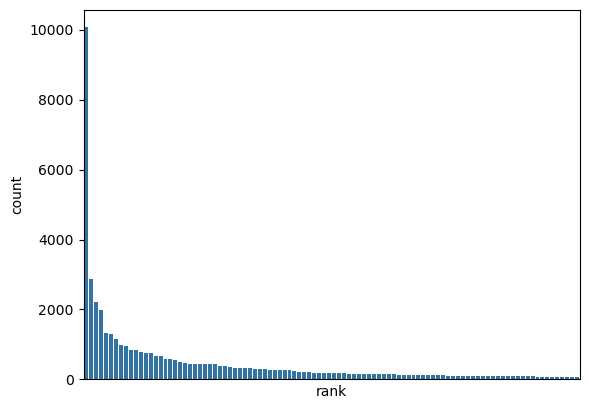

In [17]:
# distribution of categories

df_catdist = pd.DataFrame([
    (x, len(y))
    for x, y in ctp_map.items()
], columns=['category', 'count']).sort_values(by='count', ascending=False).reset_index(drop=True).reset_index().rename(columns={'index': 'rank'})

ax = sns.barplot(data=df_catdist.head(100), x='rank', y='count')
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

Distribution is very skewed, maybe we can run fairness for only the first few items

## Provider fairness factor vs Exposure by POI category

In [88]:
def load_rec_list(model_name, dataset, provider_factor = 0):
    """
    Per-line format:
    <uid>\t[<lid>,]*
    """
    dataset_sizes = {
        'Yelp': 7135,
        'Gowalla': 5628
    }
    fairness = 'None'
    if provider_factor != 0:
        fairness = 'Provider' + str(provider_factor)
    filename = f"../Outputs/Rec_{model_name}_TopK_{fairness}_{dataset}_Sum_{dataset_sizes[dataset]}user_top10_limit15.txt"

    recListsFile = open(filename, 'r').readlines()
    recLists = {}
    for dataInstance in recListsFile:
        ndx, uid, lids = dataInstance.strip().split('\t')
        uid = int(uid)
        lids = [int(l) for l in lids.split(',')]
        recLists[uid] = lids
    return recLists

rec_lists = load_rec_list('USG', 'Yelp')

In [78]:
def compute_item_exposure_by_category(rec_lists: dict, categories: list, ctp: dict = ctp_map):
    """
    Given a dict of rec lists and a list of categories ordered by popularity, compute the item exposure of the categories.
    """
    pois_of_interest = set([p for c in categories for p in ctp[c]])
    user_count = len(rec_lists)
    item_exposure = {c: 0 for c in pois_of_interest}
    for uid, lids in rec_lists.items():
        for lid in lids:
            if lid in item_exposure:
                item_exposure[lid] += 1

    category_exposure = {c: 0 for c in categories}
    for c in categories:
        for p in ctp[c]:
            category_exposure[c] += item_exposure[p]

    df_cat_exposures = pd.DataFrame([
        (c, ndx+1, category_exposure[c] / user_count)
        for ndx, c in enumerate(categories)
    ], columns=['category', 'category_rank', 'exposure'])

    return df_cat_exposures

In [40]:
compute_item_exposure_by_category(rec_lists, df_catdist.head(10)['category'].values)

,category,category_rank,exposure
0,2,1,9.144919
1,4,2,0.985704
2,9,3,3.119972
3,8,4,3.081570
4,19,5,0.045830
5,13,6,0.854660
6,79,7,0.825788
7,11,8,2.367064
8,21,9,1.327400
9,3,10,1.624807


In [41]:
_dfs = []
cats = df_catdist.head(10)['category'].values

for alpha in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    rec_lists = load_rec_list('USG', 'Yelp', alpha)
    _df = compute_item_exposure_by_category(rec_lists, cats)[['category_rank', 'exposure']]
    _df['provider_coef'] = alpha
    _dfs.append(_df)

df_catexps = pd.concat(_dfs)

In [45]:
df_catexps.head()

,category_rank,exposure,provider_coef
0,1,9.144919,0.0
1,2,0.985704,0.0
2,3,3.119972,0.0
3,4,3.081570,0.0
4,5,0.045830,0.0


In [52]:
def plot_catexp_provider_coef(df, model_name):
    fig, ax = plt.subplots(figsize=(9, 6))
    for c in df['category_rank'].unique():
        sns.lineplot(data=df[df['category_rank'] == c], x='provider_coef', y='exposure', marker='o', ax=ax, label=f"Category {c}")
    ax.legend()
    ax.set_xlabel('Provider factor coefficient')
    ax.set_ylabel('Exposure')
    ax.set_title(f'Impact of provider factor on category exposure ({model_name}, Yelp)')

    fig.savefig(f"images/{model_name}_catexposure_vs_provider_alpha.png", bbox_inches='tight')
    return fig, ax

def plot_catexp_by_model(model_name):
    _dfs = []
    cats = df_catdist.head(10)['category'].values
    
    for alpha in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        rec_lists = load_rec_list(model_name, 'Yelp', alpha)
        _df = compute_item_exposure_by_category(rec_lists, cats)[['category_rank', 'exposure']]
        _df['provider_coef'] = alpha
        _dfs.append(_df)
    
    df_catexps = pd.concat(_dfs)
    fig, ax = plot_catexp_provider_coef(df_catexps, model_name)

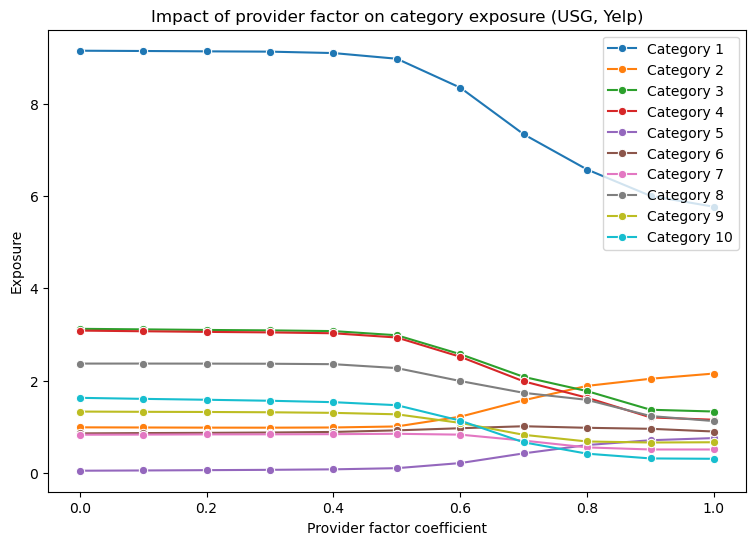

In [53]:
plot_catexp_by_model('USG')

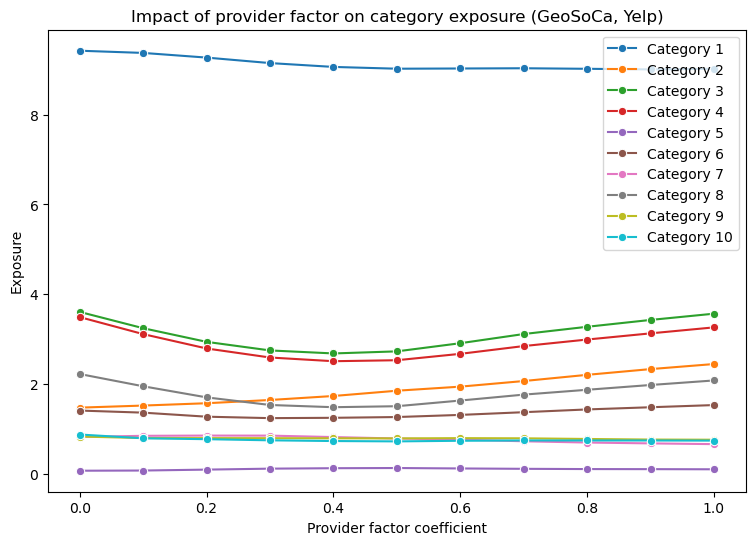

In [54]:
plot_catexp_by_model('GeoSoCa')

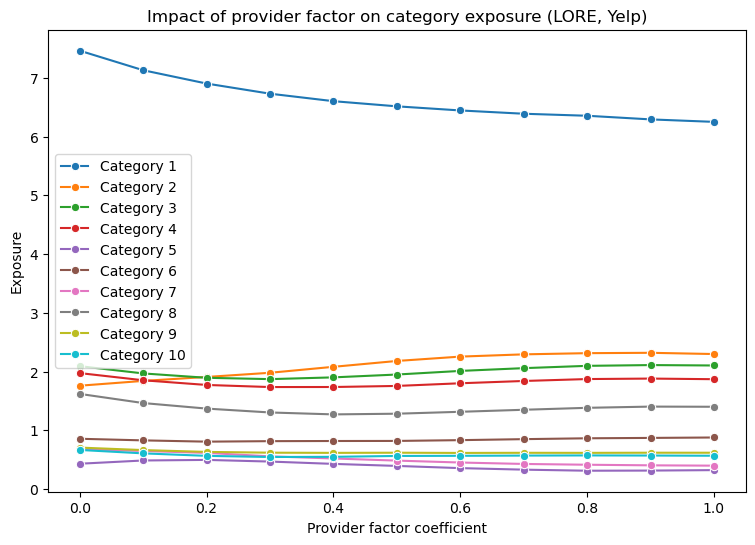

In [55]:
plot_catexp_by_model('LORE')

## Fairness impacts within categories

In [56]:
# split each per-category list into short-head and long-tail
from Models.utils import readTrainingData

_, _, poi_checkins = readTrainingData('../Data/Yelp/train.txt', 7135, 16621)

Reading training data...
Setting threshold to median repeating POI ratio of 0.7
Setting threshold to 80th prc. of POI visits of 66.0


In [57]:
poi_checkins.head()

,checkins,short_head
poi_id,,
196,1596,True
3170,1297,True
1515,1277,True
1092,1085,True
1582,1085,True


In [64]:
poi_checkins.shape

(15575, 2)

In [66]:
int(len(poi_checkins[poi_checkins.index.isin(ctp_map[3])]) * 0.2)

160

In [69]:
poi_checkins.iloc[5:, :]

,checkins,short_head
poi_id,,
2324,1069,True
3265,1053,True
3153,1043,True
1595,1036,True
1002,1015,True
...,...,...
9341,1,False
15444,1,False
16090,1,False


In [74]:
def compute_percategory_splits(ctp_map, poi_checkins, categories):
    short_heads = {}
    long_tails = {}
    for c in categories:
        _checkins = poi_checkins[poi_checkins.index.isin(ctp_map[c])]
        split_ndx = int(len(_checkins) * 0.2)
        short_heads[c] = _checkins.iloc[:split_ndx].index
        long_tails[c] = _checkins.iloc[split_ndx:].index

    return short_heads, long_tails

In [75]:
short_heads, long_tails = compute_percategory_splits(ctp_map, poi_checkins, cats)

In [76]:
short_heads[3]

Index([ 3170,  1092,  1582,  1594,  1451,  1387,  3316,  3806,  2392,  8801,
       ...
        4854,  7453,  4048, 11774,  8803, 12296,  3517,  2319, 10608,  4038],
      dtype='int64', name='poi_id', length=160)

In [77]:
long_tails[3]

Index([  172,  6264, 12116,  7927,  8123,  7696,  1103,  9181, 11211,  6040,
       ...
       10336, 15775, 11579, 15691, 16227, 16251,  9094, 15656, 15957, 14811],
      dtype='int64', name='poi_id', length=644)

In [90]:
compute_item_exposure_by_category(rec_lists, df_catdist.head(10)['category'].values, short_heads)

,category,category_rank,exposure
0,2,1,9.131044
1,4,2,0.983462
2,9,3,3.116748
3,8,4,3.078767
4,19,5,0.045830
5,13,6,0.852558
6,79,7,0.825088
7,11,8,2.355711
8,21,9,1.323616
9,3,10,1.623266


In [92]:
def plot_catexp_provider_coef_by_shlt(df_short_head, df_long_tail, model_name):
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    for c in df_short_head['category_rank'].unique():
        sns.lineplot(data=df_short_head[df_short_head['category_rank'] == c], x='provider_coef', y='exposure', marker='o', ax=axs[0], label=f"Category {c}")
        sns.lineplot(data=df_long_tail[df_long_tail['category_rank'] == c], x='provider_coef', y='exposure', marker='o', ax=axs[1], label=f"Category {c}")
    axs[0].legend()
    axs[0].set_xlabel('Provider factor coefficient')
    axs[0].set_ylabel('Exposure')
    axs[0].set_title(f'Impact of provider factor on short head category exposure ({model_name}, Yelp)')
    axs[1].legend()
    axs[1].set_xlabel('Provider factor coefficient')
    axs[1].set_ylabel('Exposure')
    axs[1].set_title(f'Impact of provider factor on long tail category exposure ({model_name}, Yelp)')

    fig.savefig(f"images/{model_name}_catexposure_by_distrib_vs_provider_alpha.png", bbox_inches='tight')
    return fig, axs

def plot_catexp_by_model_by_shlt(model_name):
    _dfs_sh = []
    _dfs_lt = []
    cats = df_catdist.head(10)['category'].values
    
    for alpha in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        rec_lists = load_rec_list(model_name, 'Yelp', alpha)
        _df_sh = compute_item_exposure_by_category(rec_lists, cats, short_heads)[['category_rank', 'exposure']]
        _df_lt = compute_item_exposure_by_category(rec_lists, cats, long_tails)[['category_rank', 'exposure']]
        _df_sh['provider_coef'] = alpha
        _dfs_sh.append(_df_sh)
        _df_lt['provider_coef'] = alpha
        _dfs_lt.append(_df_lt)
    
    df_catexps_sh = pd.concat(_dfs_sh)
    df_catexps_lt = pd.concat(_dfs_lt)
    fig, axs = plot_catexp_provider_coef_by_shlt(df_catexps_sh, df_catexps_lt, model_name)
    fig.show()
    # return df_catexps_sh, df_catexps_lt

/tmp/ipykernel_1840/4290370432.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


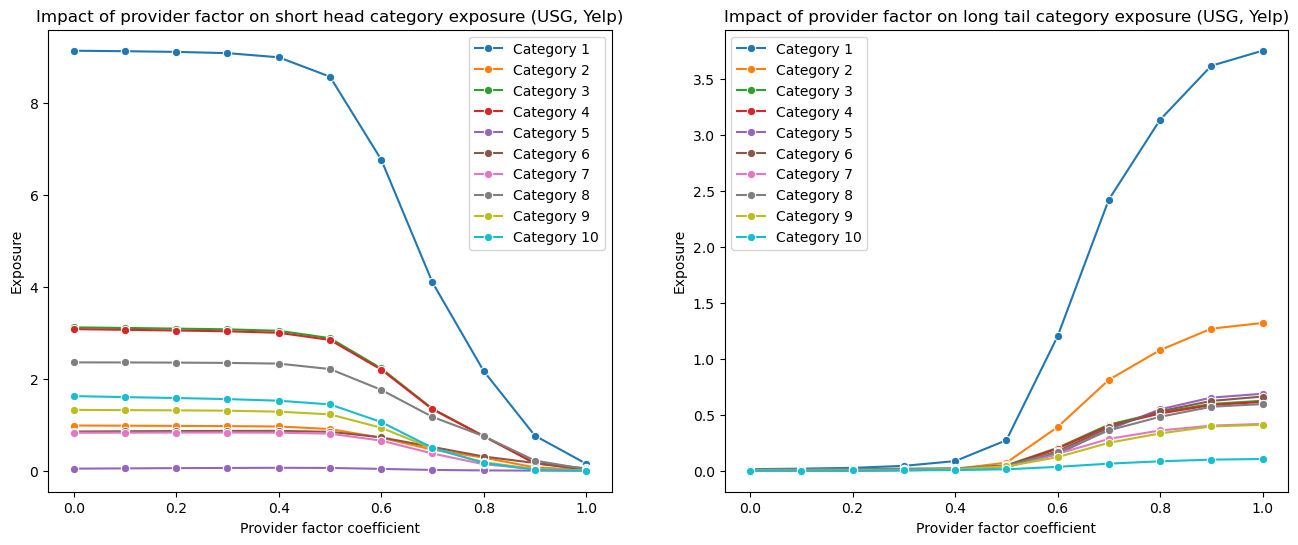

In [93]:
plot_catexp_by_model_by_shlt('USG')


/tmp/ipykernel_1840/4290370432.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


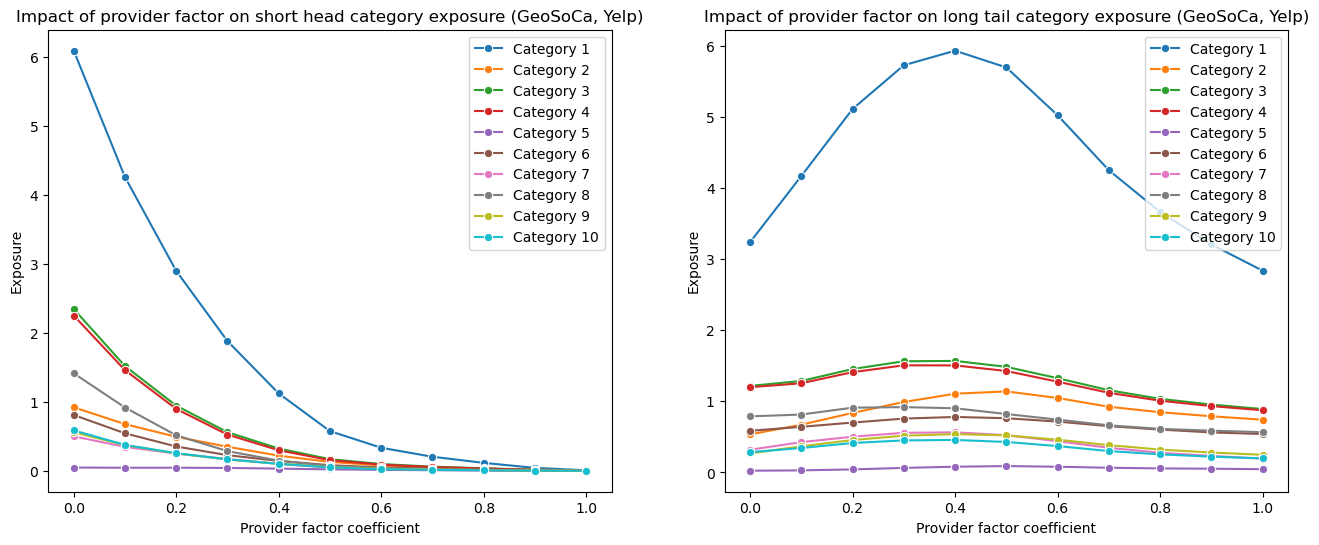

In [94]:
plot_catexp_by_model_by_shlt('GeoSoCa')


/tmp/ipykernel_1840/4290370432.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


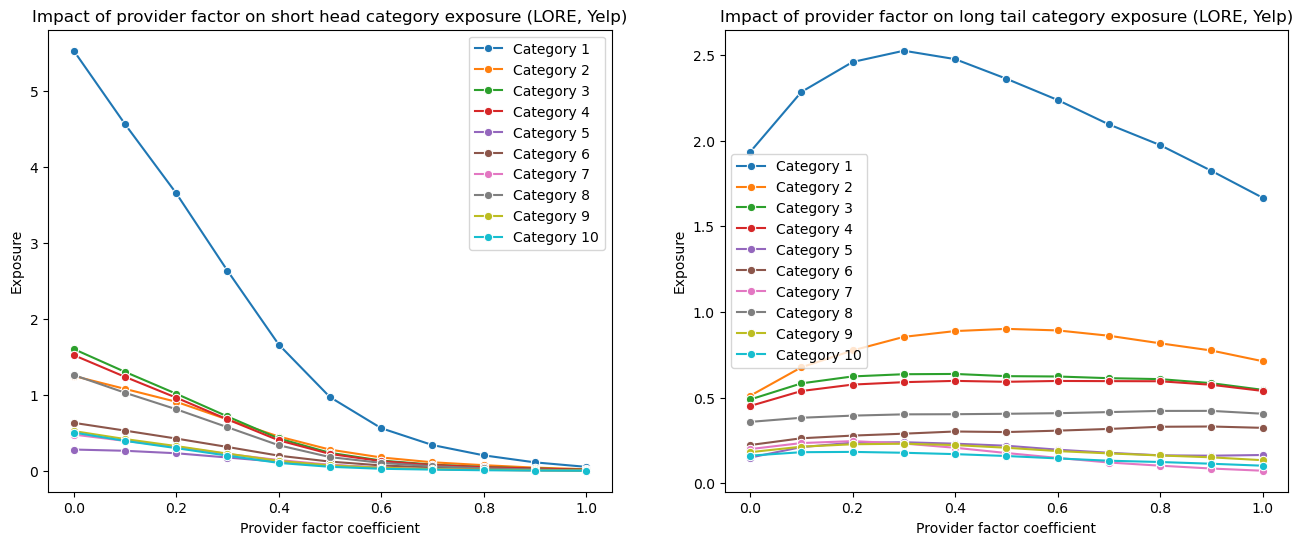

In [95]:
plot_catexp_by_model_by_shlt('LORE')
